In [1]:
#!/usr/bin/env python
# encoding: utf-8
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.layers import ActivityRegularization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator



gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=800)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
# from xgboost import XGBClassifier
import tensorflow.keras.backend as K
from sklearn import metrics

# Import local libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import importlib
import os


print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.device('/device:XLA_GPU:0')
!nvidia-smi

1 Physical GPUs, 1 Logical GPU
Tensorflow Version is 2.0.0
Keras Version is 2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6846614251971443207
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18111628374278629472
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17746186457314361635
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 838860800
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 16885635745139867462
physical_device_desc: "device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:84:00.0, compute capability: 6.0"
]
Wed Dec  2 15:25:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 10.1     |

In [2]:
# preprocess = "trimmed"
preprocess = "untrimmed"

HOMEPATH = "/dicos_ui_home/alanchung/UniversalityDNN/"
Data_High_Level_Features_path =  HOMEPATH + "Data_High_Level_Features/"


total_list = ["GEN","SHO","PRO",
              "MJ_0","PTJ_0","t21_0","D21_0","D22_0","C21_0","C22_0",
              "MJ","PTJ","t21","D21","D22","C21","C22",
              "eventindex","index"]

if os.path.exists(HOMEPATH + "Data_ML/DNN" + "_" + str(preprocess)) == 0:
    os.mkdir(HOMEPATH + "Data_ML/DNN" + "_" + str(preprocess))
    datapath = HOMEPATH + "Data_ML/"
    savepath = HOMEPATH + "Data_ML/DNN" + "_" + str(preprocess) + "/"
else: 
    datapath = HOMEPATH + "Data_ML/"
    savepath = HOMEPATH + "Data_ML/DNN" + "_" + str(preprocess) + "/"

herwig_ang_train = pd.read_csv(datapath + "herwig_ang_train" + "_" + str(preprocess) + ".csv")
herwig_ang_test = pd.read_csv(datapath + "herwig_ang_test" + "_" + str(preprocess) + ".csv")
herwig_ang_val = pd.read_csv(datapath + "herwig_ang_val" + "_" + str(preprocess) + ".csv")


pythia_def_train = pd.read_csv(datapath + "pythia_def_train" + "_" + str(preprocess) + ".csv")
pythia_def_test = pd.read_csv(datapath + "pythia_def_test" + "_" + str(preprocess) + ".csv")
pythia_def_val = pd.read_csv(datapath + "pythia_def_val" + "_" + str(preprocess) + ".csv")


pythia_vin_train = pd.read_csv(datapath + "pythia_vin_train" + "_" + str(preprocess) + ".csv")
pythia_vin_test = pd.read_csv(datapath + "pythia_vin_test" + "_" + str(preprocess) + ".csv")
pythia_vin_val = pd.read_csv(datapath + "pythia_vin_val" + "_" + str(preprocess) + ".csv")


pythia_dip_train = pd.read_csv(datapath + "pythia_dip_train" + "_" + str(preprocess) + ".csv")
pythia_dip_test = pd.read_csv(datapath + "pythia_dip_test" + "_" + str(preprocess) + ".csv")
pythia_dip_val = pd.read_csv(datapath + "pythia_dip_val" + "_" + str(preprocess) + ".csv")


sherpa_def_train = pd.read_csv(datapath + "sherpa_def_train" + "_" + str(preprocess) + ".csv")
sherpa_def_test = pd.read_csv(datapath + "sherpa_def_test" + "_" + str(preprocess) + ".csv")
sherpa_def_val = pd.read_csv(datapath + "sherpa_def_val" + "_" + str(preprocess) + ".csv")


if preprocess == "trimmed":
    features = ["MJ","t21","D21","D22","C21","C22"]
    
if preprocess == "untrimmed":   
    features = ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0"]


DNN_Model = ["herwig_ang", "pythia_def", "pythia_vin", "pythia_dip", "sherpa_def"]
DNN_model_name = ["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Sherpa Default"]

XTRAIN = [herwig_ang_train[features],pythia_def_train[features],
         pythia_vin_train[features],pythia_dip_train[features],
         sherpa_def_train[features]]

YTRAIN = [herwig_ang_train["target"],pythia_def_train["target"],
         pythia_vin_train["target"],pythia_dip_train["target"],
         sherpa_def_train["target"]]


XVAL = [herwig_ang_val[features],pythia_def_val[features],
         pythia_vin_val[features],pythia_dip_val[features],
         sherpa_def_val[features]]

YVAL = [herwig_ang_val["target"],pythia_def_val["target"],
         pythia_vin_val["target"],pythia_dip_val["target"],
         sherpa_def_val["target"]]


XTEST = [herwig_ang_test[features],pythia_def_test[features],
         pythia_vin_test[features],pythia_dip_test[features],
         sherpa_def_test[features]]

YTEST = [herwig_ang_test["target"],pythia_def_test["target"],
         pythia_vin_test["target"],pythia_dip_test["target"],
         sherpa_def_test["target"]]

print("W jet : QCD jet = 1 : 1")
print("\r")
print("{:^8}{:^15}{:^15}{:^15}{:^15}{:^15}".format("","Herwig Angular","Pythia Default","Pythia Vincia","Pythia Dipole","Sherpa Default"))
print("{:^8}{:^15}{:^15}{:^15}{:^15}{:^15}".format("Train #",len(herwig_ang_train),len(pythia_def_train),len(pythia_vin_train),len(pythia_dip_train),len(sherpa_def_train)))
print("{:^8}{:^15}{:^15}{:^15}{:^15}{:^15}".format("Test #",len(herwig_ang_test),len(pythia_def_test),len(pythia_vin_test),len(pythia_dip_test),len(sherpa_def_test)))
print("{:^8}{:^15}{:^15}{:^15}{:^15}{:^15}".format("Val. #",len(herwig_ang_val),len(pythia_def_val),len(pythia_vin_val),len(pythia_dip_val),len(sherpa_def_val)))


W jet : QCD jet = 1 : 1

        Herwig Angular Pythia Default  Pythia Vincia  Pythia Dipole Sherpa Default 
Train #     101222         101222         101222         101222         101222     
 Test #      12652          12652          12652          12652          12652     
 Val. #      12652          12652          12652          12652          12652     


In [3]:
######################################################################################
# time counter
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
############################################################################################################################################################
DNN = 0
for i, filename in enumerate(os.listdir(savepath)):
#     if filename == DNN_Model[i]+"_DNN" + "_" + str(preprocess) + ".h5" :
    length = -int(len(str(preprocess))+3)
    if filename[length:] == str(preprocess) + ".h5" :
        DNN += 1 

if DNN == 0:

    for i, element in enumerate(DNN_Model[:]):

        model_DNN_1 = Sequential(name = "Sequential_DNN_"+str(DNN_Model[i]))



        model_DNN_1.add(keras.Input(shape=(len(features),), name = 'input'))
    #     model_DNN_1.add(Dense(256, activation='relu', name = 'dense_1'))
        model_DNN_1.add(Dense(64, activation='relu', name = 'dense_1'))
        model_DNN_1.add(Dense(32, activation='relu', name = 'dense_2'))
    #     model_DNN_1.add(Dense(32, activation='relu', name = 'dense_4'))
        model_DNN_1.add(Dense(1, activation='sigmoid', name = 'dense_3'))
    #     model_DNN_1.add(ActivityRegularization(l2=0.1, name = 'Regularization'))
        model_DNN_1.add(Dropout(0.00001))


        model_DNN_1.summary()

        # model_opt = keras.optimizers.Adadelta()
        model_opt = keras.optimizers.Adam()
        model_DNN_1.compile(loss="binary_crossentropy",#keras.losses.binary_crossentropy
                              optimizer=model_opt,
                              metrics=['accuracy'])
        ######################################################################################
        # time counter
        print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
        ticks_1 = time.time()
        ############################################################################################################################################################


        check_list=[]
        csv_logger = CSVLogger(savepath + DNN_Model[i] + "_training_log.csv")
        checkpoint = ModelCheckpoint(
                            filepath= savepath + DNN_Model[i] + "_checkmodel.h5",
                            save_best_only=True,
                            verbose=0)
        earlystopping = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=20,
                            verbose=0,
                            mode="auto",
                            baseline=None,
                            restore_best_weights=False,
                        )
        
        check_list.append(checkpoint)
        check_list.append(csv_logger)
        check_list.append(earlystopping)
        model_DNN_1.fit(np.asarray(XTRAIN[i]), np.asarray(YTRAIN[i]),
                        validation_data = (np.asarray(XVAL[i]), np.asarray(YVAL[i])),
                        batch_size=64,
                        epochs=100,
                        callbacks=check_list,
                        verbose=1)

        model_DNN_1.save(savepath + DNN_Model[i] + "_DNN" + "_" + str(preprocess) + ".h5")

        ############################################################################################################################################################
        ticks_2 = time.time()
        totaltime =  ticks_2 - ticks_1
        print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
        
if DNN == 5:
    print("We have prepared models !!")
     
    

############################################################################################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))


Wed Dec 02 15:25:15 2020
We have prepared models !!
Time Cost : 0.0000 min


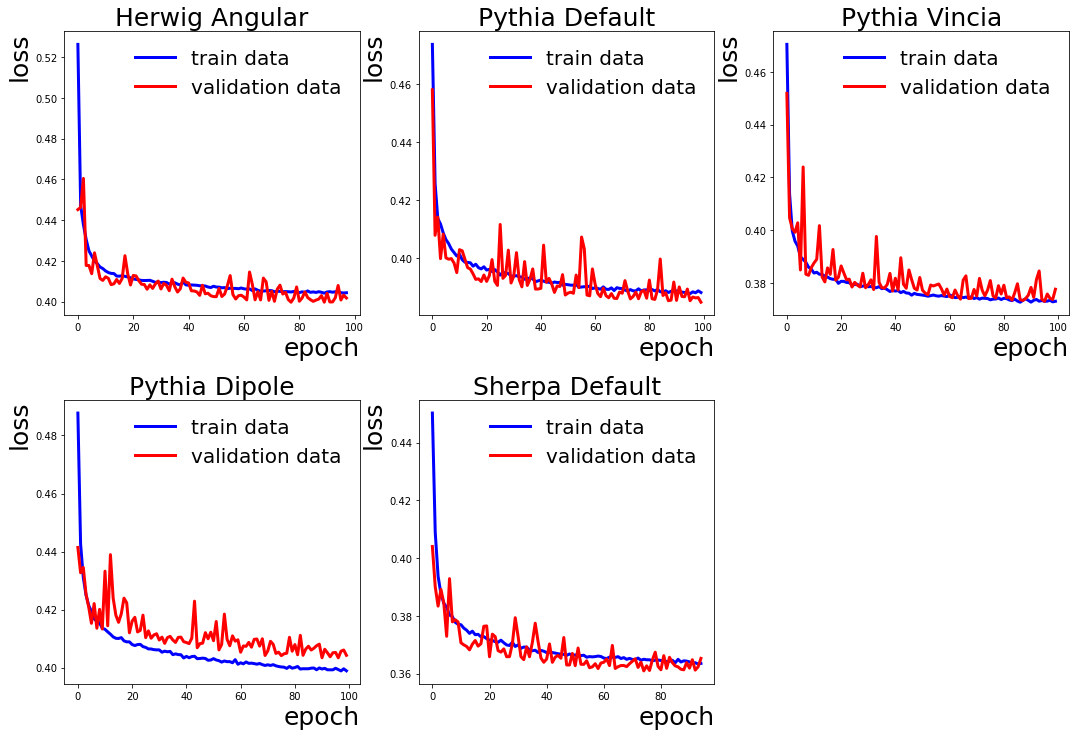

In [4]:
# HOMEPATH = "/dicos_ui_home/alanchung/UniversalityDNN/"
# Data_High_Level_Features_path =  HOMEPATH + "Data_High_Level_Features/"
# savepath = HOMEPATH + "Data_ML/DNN" + "_" + str(preprocess) + "/"

# DNN_Model = ["herwig_ang", "pythia_def", "pythia_vin", "pythia_dip", "sherpa_def"]
# DNN_model_name = ["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Sherpa Default"]

plt.figure(figsize=(18,12))
for i, model in enumerate(DNN_Model):
    plot_axis = plt.subplot(2,3,i+1)
    
#     fig.subplots_adjust(bottom=0.18, left=0.18, top=0.95, right=0.95)
    LOSS = pd.read_csv(savepath + model + "_training_log.csv")

#     plt.tick_params(which='both', width=2)
#     plt.tick_params(which='major', length=8)
#     plt.tick_params(which='minor', length=4, color='k')
    plot_axis.plot(LOSS["loss"], label='train data',c='blue',linewidth = 3)
    plot_axis.plot(LOSS["val_loss"], label='validation data',c='red',linewidth = 3)

    plt.title(DNN_model_name[i], fontsize=25)

    plot_axis.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
    plot_axis.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
    plot_axis.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

#     plt.tick_params(which='minor',width=0)
#     plt.tick_params(labelsize=25)
    # plt.savefig("./Figures/learning_curve_w_noise.pdf", transparent=True)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

In [5]:
AUC = np.zeros((5,5))
max_sig = np.zeros((5,5))
r05 = np.zeros((5,5))

for i, model in enumerate(DNN_Model):
#     print(model)
    for j, test_generator in enumerate(XTEST):
        
        DNN = load_model(savepath + DNN_Model[i] + "_DNN" + "_" + str(preprocess) + ".h5")

        prediction_DNN_test = DNN.predict(np.asarray(test_generator))

        discriminator_test = prediction_DNN_test

        discriminator_test = discriminator_test/(max(discriminator_test))

        AUC[i,j] = metrics.roc_auc_score(YTEST[i],discriminator_test)
        FalsePositiveFull, TruePositiveFull, _ = metrics.roc_curve(YTEST[i],discriminator_test)
#         print(FalsePositiveFull_GBDT_test[10:], TruePositiveFull_GBDT_test[10:])
#         print(len(FalsePositiveFull),len(TruePositiveFull),len(YTEST[i]))
        aaa = np.where(TruePositiveFull > 0.1)
        max_sig[i,j] = max(TruePositiveFull[aaa]/np.sqrt(FalsePositiveFull[aaa])) 
        bbb = np.where(TruePositiveFull >= 0.5)
        r05[i,j] = 1./FalsePositiveFull[bbb[0][0]]

print("Models are trained by row and test to column.")
print("Performance in AUC")
print("\r")
print("{:^15}{:^15}{:^15}{:^15}{:^15}{:^15}".format("","Herwig Angular","Pythia Default","Pythia Vincia","Pythia Dipole","Sherpa Default"))
for i in range(5):
    print("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format(DNN_model_name[i],AUC[i,0], AUC[i,1], AUC[i,2], AUC[i,3], AUC[i,4]))
print("\r")
print("Performance in Max Significance")
print("\r")
for i in range(5):
    print("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format(DNN_model_name[i],max_sig[i,0], max_sig[i,1], max_sig[i,2], max_sig[i,3], max_sig[i,4]))
print("\r")
print("1/fpr @ tpr = 0.5 (rejection at 50% signal efficiency)")
print("\r")
for i in range(5):
    print("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format(DNN_model_name[i],r05[i,0], r05[i,1], r05[i,2], r05[i,3], r05[i,4]))


Models are trained by row and test to column.
Performance in AUC

               Herwig Angular Pythia Default  Pythia Vincia  Pythia Dipole Sherpa Default 
Herwig Angular      0.880          0.900          0.902          0.885          0.909     
Pythia Default      0.881          0.901          0.902          0.885          0.909     
 Pythia Vincia      0.879          0.900          0.900          0.885          0.907     
 Pythia Dipole      0.882          0.901          0.902          0.886          0.908     
Sherpa Default      0.880          0.899          0.901          0.884          0.909     

Performance in Max Significance

Herwig Angular      5.724          5.524          6.485          6.654          5.143     
Pythia Default      5.554          5.688          6.816          6.649          5.388     
 Pythia Vincia      5.497          5.573          5.983          8.600          5.589     
 Pythia Dipole      5.392          5.475          6.228          8.198          5

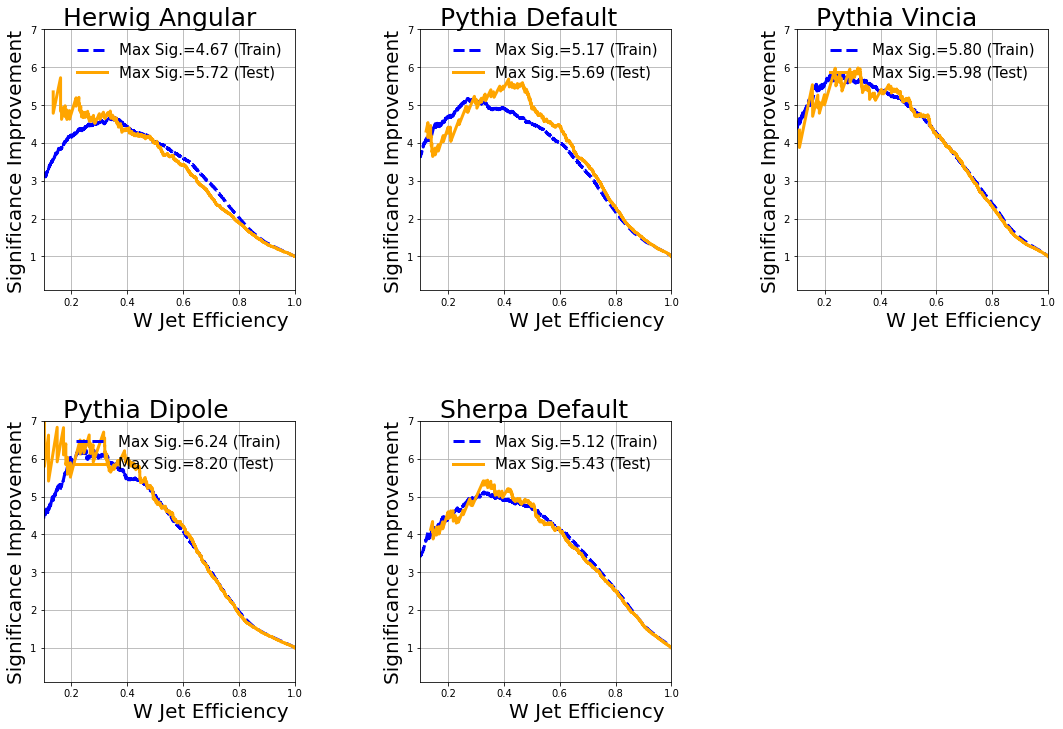

In [16]:
axis = 1
if axis == 0:
    process = "QCD"
elif axis == 1:
    process = "W Jet"

plt.figure(figsize=(18,12))
for i, model in enumerate(DNN_Model):
    plot_axis = plt.subplot(2,3,i+1)

    DNN = load_model(savepath + DNN_Model[i] + "_DNN" + "_" + str(preprocess) + ".h5")

    prediction_DNN_test = DNN.predict_proba(np.asarray(XTEST[i]))
    prediction_DNN_train = DNN.predict_proba(np.asarray(XTRAIN[i]))

    discriminator_test = prediction_DNN_test
    discriminator_train = prediction_DNN_train

    discriminator_test = discriminator_test/(max(discriminator_test))
    discriminator_train = discriminator_train/(max(discriminator_train))
    


    test_auc_DNN_test = metrics.roc_auc_score(YTEST[i],discriminator_test)
    FalsePositiveFull_DNN_test, TruePositiveFull_DNN_test, _ = metrics.roc_curve(YTEST[i],discriminator_test)

    train_auc_DNN_train = metrics.roc_auc_score(YTRAIN[i],discriminator_train)
    FalsePositiveFull_DNN_train, TruePositiveFull_DNN_train, _ = metrics.roc_curve(YTRAIN[i],discriminator_train)
 
    a = np.where(TruePositiveFull_DNN_test > 0.1)
    b = np.where(TruePositiveFull_DNN_train > 0.1)
#     plt.plot(TruePositiveFull_CNN_test,1-FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
    max_sig_test = max(TruePositiveFull_DNN_test[a]/np.sqrt(FalsePositiveFull_DNN_test[a]))
    max_sig_train = max(TruePositiveFull_DNN_train[b]/np.sqrt(FalsePositiveFull_DNN_train[b]))
    plt.plot(TruePositiveFull_DNN_train[b],TruePositiveFull_DNN_train[b]/np.sqrt(FalsePositiveFull_DNN_train[b]),"--", color='b', linewidth = 3, label='Max Sig.={0:.2f} (Train)'.format(max_sig_train))
    plt.plot(TruePositiveFull_DNN_test[a],TruePositiveFull_DNN_test[a]/np.sqrt(FalsePositiveFull_DNN_test[a]),"-", color='orange', linewidth = 3, label='Max Sig.={0:.2f} (Test)'.format(max_sig_test))

# plt.scatter(0.75,1./0.32, marker="D", s=300 , c='b')
# plt.scatter(0.70,1./0.13, marker="D", s=300 , c='orange')

    plot_axis.set_xlim((0,1))
    plot_axis.set_ylim((0.1,7))
    # plt.yscale("log")
    plt.xlim((0,1))
#     plt.ylim((1, 1E+4))
#     plt.yscale("log")
#     plot_axis.set_tick_params(axis='x', labelsize=25)
#     plot_axis.set_tick_params(axis='y', labelsize=25)
    # ax.yaxis.set_major_locator(MaxNLocator(5))
    # ax.xaxis.set_major_locator(MaxNLocator(5))
    plot_axis.set_xlabel(str(process)+' Efficiency ', fontsize=20,horizontalalignment='right',x=1)
    plot_axis.set_ylabel('Significance Improvement', fontsize=20,horizontalalignment='right',y=1)
    plot_axis.legend(ncol=1,fontsize=15, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
#     plt.tight_layout()
    plot_axis.text(x=0.17, y=7.1, s=str(DNN_model_name[i]),fontsize=25) 

    plot_axis.set_xlim((0.1,1))
#     plot_axis.set_ylim((1, 2E+2))
#     plot_axis.set_yscale("log")
    plot_axis.grid()
# plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


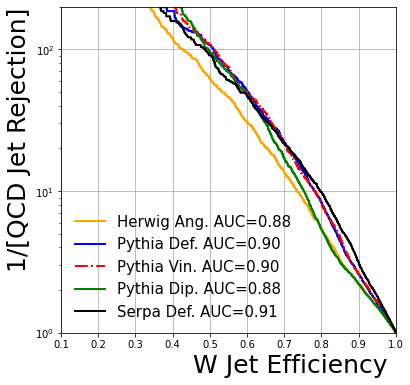

In [18]:
axis = 1
if axis == 0:
    process = "QCD"
elif axis == 1:
    process = "W Jet"

plt.figure(figsize=(6,6))

DNN = load_model(savepath + DNN_Model[i] + "_DNN" + "_" + str(preprocess) + ".h5")

prediction_DNN_herwig_ang = DNN.predict_proba(np.asarray(XTEST[0]))
prediction_DNN_pythia_def = DNN.predict_proba(np.asarray(XTEST[1]))
prediction_DNN_pythia_vin= DNN.predict_proba(np.asarray(XTEST[2]))
prediction_DNN_pythia_dip = DNN.predict_proba(np.asarray(XTEST[3]))
prediction_DNN_sherpa_def = DNN.predict_proba(np.asarray(XTEST[4]))


# discriminator_test = discriminator_test/(max(discriminator_test))
# discriminator_train = discriminator_train/(max(discriminator_train))
    


test_auc_herwig_ang = metrics.roc_auc_score(YTEST[0],prediction_DNN_herwig_ang)
FalsePositiveFull_herwig_ang, TruePositiveFull_herwig_ang, _ = metrics.roc_curve(YTEST[0],prediction_DNN_herwig_ang)

test_auc_pythia_def = metrics.roc_auc_score(YTEST[1],prediction_DNN_pythia_def)
FalsePositiveFull_pythia_def, TruePositiveFull_pythia_def, _ = metrics.roc_curve(YTEST[1],prediction_DNN_pythia_def)

test_auc_pythia_vin = metrics.roc_auc_score(YTEST[2],prediction_DNN_pythia_vin)
FalsePositiveFull_pythia_vin, TruePositiveFull_pythia_vin, _ = metrics.roc_curve(YTEST[2],prediction_DNN_pythia_vin)

test_auc_pythia_dip = metrics.roc_auc_score(YTEST[3],prediction_DNN_pythia_dip)
FalsePositiveFull_pythia_dip, TruePositiveFull_pythia_dip, _ = metrics.roc_curve(YTEST[3],prediction_DNN_pythia_dip)

test_auc_sherpa_def = metrics.roc_auc_score(YTEST[4],prediction_DNN_sherpa_def)
FalsePositiveFull_sherpa_def, TruePositiveFull_sherpa_def, _ = metrics.roc_curve(YTEST[4],prediction_DNN_sherpa_def)

#     plt.plot(TruePositiveFull_CNN_test,1-FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
#     plt.plot(TruePositiveFull_CNN_train,1-FalsePositiveFull_CNN_train,"--", color='b', linewidth = 3, label='AUC={0:.2f} (Train)'.format(train_auc_CNN_train))
plt.plot(TruePositiveFull_herwig_ang,1./FalsePositiveFull_herwig_ang,"-", color='orange', linewidth = 2, label='Herwig Ang. AUC={0:.2f}'.format(test_auc_herwig_ang))
plt.plot(TruePositiveFull_pythia_def,1./FalsePositiveFull_pythia_def,"-", color='b', linewidth = 2, label='Pythia Def. AUC={0:.2f}'.format(test_auc_pythia_def))
plt.plot(TruePositiveFull_pythia_vin,1./FalsePositiveFull_pythia_vin,"-.", color='r', linewidth = 2, label='Pythia Vin. AUC={0:.2f}'.format(test_auc_pythia_vin))
plt.plot(TruePositiveFull_pythia_dip,1./FalsePositiveFull_pythia_dip,"-", color='g', linewidth = 2, label='Pythia Dip. AUC={0:.2f}'.format(test_auc_pythia_dip))
plt.plot(TruePositiveFull_sherpa_def,1./FalsePositiveFull_sherpa_def,"-", color='k', linewidth = 2, label='Serpa Def. AUC={0:.2f}'.format(test_auc_sherpa_def))

# plt.scatter(0.75,1./0.32, marker="D", s=300 , c='b')
# plt.scatter(0.70,1./0.13, marker="D", s=300 , c='orange')


plt.xlim((0.1,1))
plt.ylim((1, 2E+2))
plt.yscale("log")
#     plot_axis.set_tick_params(axis='x', labelsize=25)
#     plot_axis.set_tick_params(axis='y', labelsize=25)
    # ax.yaxis.set_major_locator(MaxNLocator(5))
    # ax.xaxis.set_major_locator(MaxNLocator(5))
plt.xlabel(str(process)+' Efficiency ', fontsize=25,horizontalalignment='right',x=1)
plt.ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1)
plt.legend(ncol=1,fontsize=15, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
#     plt.tight_layout()
# plt.text(x=0.17, y=1.03, s=str(CNN_model_name[i]),fontsize=25) 
plt.grid()
# plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()